In [33]:
import pandas as pd
import os

In [34]:
def get_columns(file_path):
    with open(file_path, "r") as rf:
        original_file_path = rf.readline()
        original_file_path = original_file_path.replace("../", "")
        print(original_file_path)
        with open(os.path.join("data", original_file_path)) as f:
            column_line = f.readline()
            columns = column_line.split("=")[1]
            columns = [c.strip() for c in columns.split(" ") if c]
            return columns


In [35]:
get_columns("./data/train-devel-test/train/fiction/no-morph/chilcote_12.conllup")

genres/fiction/no-morph/chilcote_12.conllup


['FORM', 'LEMMA', 'UPOS', 'XPOS', 'FEATS', 'CONLL:NER']

In [36]:
def load_conllup_file(file_path):
    conllu_columns = get_columns("./data/train-devel-test/train/fiction/no-morph/chilcote_12.conllup")
    df = pd.DataFrame(columns=["sentence_index", "position_number_in_sentence", *conllu_columns])
    with open(file_path, encoding="UTF-8") as f:
        sentence_index = 0
        position_number_in_sentence = 0
        line = f.readline() # skip the first comment line
        line = f.readline()
        while line:
            if line == "\n":
                sentence_index +=  1
                position_number_in_sentence = 0
            else:
                splitted_line = line.split()
                conllu_row_part = {}
                for i in range(len(conllu_columns)):
                    conllu_row_part[f"{conllu_columns[i]}"] = splitted_line[i]
                
                row = {
                    "sentence_index": sentence_index,
                    "position_number_in_sentence": position_number_in_sentence,
                    **conllu_row_part
                }
                row = pd.Series(row)
                df.loc[len(df)] = row
                position_number_in_sentence += 1
            line = f.readline()
        return df

In [37]:
df = load_conllup_file("./data/train-devel-test/train/fiction/no-morph/chilcote_12.conllup")

genres/fiction/no-morph/chilcote_12.conllup


In [4]:
df.head(5)

NameError: name 'df' is not defined

In [38]:
df["CONLL:NER"].value_counts()

Series([], Name: CONLL:NER, dtype: int64)

In [39]:
import os

In [40]:
train_test_devel_data_path = os.path.join("data", "train-devel-test")
train_test_devel_data_dirs = [os.path.join(train_test_devel_data_path, data_dir) for data_dir in os.listdir(train_test_devel_data_path) if os.path.isdir(os.path.join(train_test_devel_data_path, data_dir))]

In [46]:
def get_train_devel_test_conllup_file_dirs():
    train_devel_test_conllup_file_dirs = {}
    for d in train_test_devel_data_dirs:
        connlup_file_dirs = [os.path.join(d, genre_dir, "no-morph") for genre_dir in os.listdir(d) if os.path.isdir(os.path.join(d, genre_dir)) and "no-morph" in os.listdir(os.path.join(d, genre_dir))]
        train_devel_test_conllup_file_dirs[os.path.basename(d)] = connlup_file_dirs
    return train_devel_test_conllup_file_dirs

In [42]:
import re
connlup_file_pattern = re.compile(".*.conllup") 
def get_connlup_files_in_dir(path_to_dir):
    return [f for f in os.listdir(path_to_dir) if connlup_file_pattern.match(f)]

In [47]:
get_train_devel_test_conllup_file_dirs()

{'devel': ['data\\train-devel-test\\devel\\fiction\\no-morph',
  'data\\train-devel-test\\devel\\legal\\no-morph',
  'data\\train-devel-test\\devel\\news\\no-morph',
  'data\\train-devel-test\\devel\\wikipedia\\no-morph'],
 'test': ['data\\train-devel-test\\test\\fiction\\no-morph',
  'data\\train-devel-test\\test\\legal\\no-morph',
  'data\\train-devel-test\\test\\news\\no-morph',
  'data\\train-devel-test\\test\\wikipedia\\no-morph'],
 'train': ['data\\train-devel-test\\train\\fiction\\no-morph',
  'data\\train-devel-test\\train\\legal\\no-morph',
  'data\\train-devel-test\\train\\news\\no-morph',
  'data\\train-devel-test\\train\\wikipedia\\no-morph']}

In [44]:
get_connlup_files_in_dir(train_devel_test_conllup_file_dirs["devel"][0])

['chilcote_16.conllup',
 'opensubtitles_1.conllup',
 'opensubtitles_10.conllup',
 'opensubtitles_11.conllup',
 'opensubtitles_13.conllup',
 'opensubtitles_14.conllup',
 'opensubtitles_15.conllup',
 'opensubtitles_16.conllup',
 'opensubtitles_17.conllup',
 'opensubtitles_18.conllup',
 'opensubtitles_19.conllup',
 'opensubtitles_2.conllup',
 'tanarur_1.conllup',
 'tokmag_3.conllup']

In [45]:
def load_all_conllup_files_in_dir(path_to_dir, train_test_devel, genre):
    conllup_file_paths = [os.path.join(path_to_dir, cf) for cf in get_connlup_files_in_dir(path_to_dir)]
    combined_df = pd.DataFrame()
    for conllup_file in conllup_file_paths:
        print(conllup_file)
        df = load_conllup_file(conllup_file)
        df["train_test_devel"] = train_test_devel
        df["genre"] = genre
        df["file_path"] = conllup_file
        combined_df = pd.concat([combined_df, df])
    return combined_df


In [63]:
data = load_all_conllup_files_in_dir(train_devel_test_conllup_file_dirs["devel"][0], "devel",train_devel_test_conllup_file_dirs["devel"][0].split(os.path.sep)[-2])

data\train-devel-test\devel\fiction\no-morph\chilcote_16.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_1.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_10.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_11.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_13.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_14.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_15.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_16.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_17.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_18.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_19.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_2.conllup
data\train-devel-test\devel\fiction\no-morph\tanarur_1.conllup
data\train-devel-test\devel\fiction\no-morph\tokmag_3.conllup


In [69]:

word_counts = {}
for data_set in train_devel_test_conllup_file_dirs:
    word_counts[data_set] = {}
    for genre_dir in train_devel_test_conllup_file_dirs[data_set]:
        print(genre_dir)
        genre = genre_dir.split(os.path.sep)[-2]
        df = load_all_conllup_files_in_dir(genre_dir, data_set, genre)
        word_counts[data_set][genre] = {"word_count": len(df), "unique_words": len(df["FORM"].unique())}
print(word_counts)


data\train-devel-test\devel\fiction\no-morph
data\train-devel-test\devel\fiction\no-morph\chilcote_16.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_1.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_10.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_11.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_13.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_14.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_15.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_16.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_17.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_18.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_19.conllup
data\train-devel-test\devel\fiction\no-morph\opensubtitles_2.conllup
data\train-devel-test\devel\fiction\no-morph\tanarur_1.conllup
data\train-devel-test\devel\fiction\no-morph\tokmag_3.conll

data\train-devel-test\train\fiction\no-morph\opensubtitles_73.conllup
data\train-devel-test\train\fiction\no-morph\opensubtitles_74.conllup
data\train-devel-test\train\fiction\no-morph\opensubtitles_75.conllup
data\train-devel-test\train\fiction\no-morph\opensubtitles_76.conllup
data\train-devel-test\train\fiction\no-morph\opensubtitles_77.conllup
data\train-devel-test\train\fiction\no-morph\opensubtitles_78.conllup
data\train-devel-test\train\fiction\no-morph\opensubtitles_79.conllup
data\train-devel-test\train\fiction\no-morph\opensubtitles_8.conllup
data\train-devel-test\train\fiction\no-morph\opensubtitles_80.conllup
data\train-devel-test\train\fiction\no-morph\opensubtitles_81.conllup
data\train-devel-test\train\fiction\no-morph\opensubtitles_82.conllup
data\train-devel-test\train\fiction\no-morph\opensubtitles_83.conllup
data\train-devel-test\train\fiction\no-morph\opensubtitles_84.conllup
data\train-devel-test\train\fiction\no-morph\opensubtitles_85.conllup
data\train-devel-test

data\train-devel-test\train\wikipedia\no-morph\huwiki_200_27.conllup
data\train-devel-test\train\wikipedia\no-morph\huwiki_200_28.conllup
data\train-devel-test\train\wikipedia\no-morph\huwiki_200_29.conllup
data\train-devel-test\train\wikipedia\no-morph\huwiki_200_3.conllup
data\train-devel-test\train\wikipedia\no-morph\huwiki_200_30.conllup
data\train-devel-test\train\wikipedia\no-morph\huwiki_200_31.conllup
data\train-devel-test\train\wikipedia\no-morph\huwiki_200_32.conllup
data\train-devel-test\train\wikipedia\no-morph\huwiki_200_33.conllup
data\train-devel-test\train\wikipedia\no-morph\huwiki_200_34.conllup
data\train-devel-test\train\wikipedia\no-morph\huwiki_200_35.conllup
data\train-devel-test\train\wikipedia\no-morph\huwiki_200_36.conllup
data\train-devel-test\train\wikipedia\no-morph\huwiki_200_37.conllup
data\train-devel-test\train\wikipedia\no-morph\huwiki_200_38.conllup
data\train-devel-test\train\wikipedia\no-morph\huwiki_200_39.conllup
data\train-devel-test\train\wikiped

In [67]:
import json
with open("word_count.json", "w") as f:
    json.dump(word_counts, f )

In [191]:
get_train_devel_test_conllup_file_dirs
def load_csv_files_from_dir(path_to_dir):
    csv_files = [os.path.join(path_to_dir,f) for f in os.listdir(path_to_dir) if f.find(".csv") != -1]
    df = pd.DataFrame()
    for csv_file in csv_files:
        temp_df = pd.read_csv(csv_file, index_col=0)
        df = pd.concat([df, temp_df])
    return df

In [70]:
load_csv_files_from_dir(get_train_devel_test_conllup_file_dirs()["test"][0])

['data\\train-devel-test\\test\\fiction\\no-morph\\chilcote_1.csv', 'data\\train-devel-test\\test\\fiction\\no-morph\\opensubtitles_20.csv', 'data\\train-devel-test\\test\\fiction\\no-morph\\opensubtitles_21.csv', 'data\\train-devel-test\\test\\fiction\\no-morph\\opensubtitles_22.csv', 'data\\train-devel-test\\test\\fiction\\no-morph\\opensubtitles_25.csv', 'data\\train-devel-test\\test\\fiction\\no-morph\\opensubtitles_28.csv', 'data\\train-devel-test\\test\\fiction\\no-morph\\opensubtitles_29.csv', 'data\\train-devel-test\\test\\fiction\\no-morph\\opensubtitles_3.csv', 'data\\train-devel-test\\test\\fiction\\no-morph\\opensubtitles_30.csv', 'data\\train-devel-test\\test\\fiction\\no-morph\\opensubtitles_31.csv', 'data\\train-devel-test\\test\\fiction\\no-morph\\opensubtitles_50.csv', 'data\\train-devel-test\\test\\fiction\\no-morph\\tanarur_7.csv', 'data\\train-devel-test\\test\\fiction\\no-morph\\tokmag_2.csv']
      Unnamed: 0  sentence_index  position_number_in_sentence     FORM L

In [72]:
import json
with open("word_count.json", "r") as f:
    word_count = json.load(f)
    print(word_count)

{'devel': {'fiction': {'word_count': 20870, 'unique_words': 6294}, 'legal': {'word_count': 22647, 'unique_words': 6858}, 'news': {'word_count': 19849, 'unique_words': 7726}, 'wikipedia': {'word_count': 20066, 'unique_words': 7724}}, 'test': {'fiction': {'word_count': 20814, 'unique_words': 6425}, 'legal': {'word_count': 22040, 'unique_words': 7041}, 'news': {'word_count': 20848, 'unique_words': 7838}, 'wikipedia': {'word_count': 19378, 'unique_words': 7704}}, 'train': {'fiction': {'word_count': 161410, 'unique_words': 31070}, 'legal': {'word_count': 158152, 'unique_words': 28352}, 'news': {'word_count': 163779, 'unique_words': 36976}, 'wikipedia': {'word_count': 154517, 'unique_words': 35972}}}


In [83]:
import matplotlib.pyplot as plt
import numpy as np

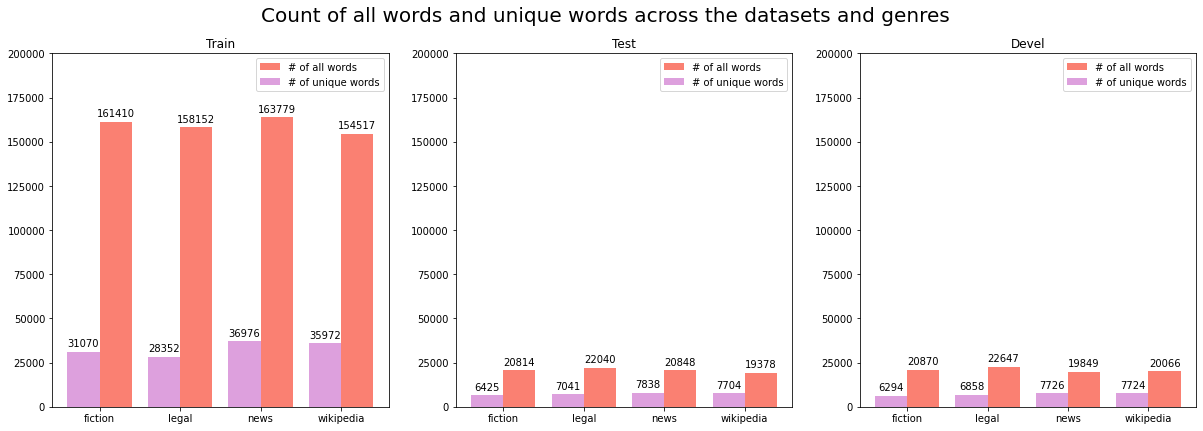

In [254]:

def plot_word_counts(word_counts):
    datasets = [dataset for dataset in word_counts]
    fig, ax = plt.subplots(1,len(datasets))
    fig.suptitle("Count of all words and unique words across the datasets and genres",  fontsize=20)
    fig.set_size_inches(20.5, 6.5)
    for i, dataset in enumerate(reversed(datasets)):
        genres = [genre for genre in word_counts[dataset]]
        width = 0.4
        x = np.arange(len(genres))
        y_values = {}
        for genre in genres:
            for word_count in word_counts[dataset][genre]:
                if word_count not in y_values:
                    y_values[word_count] = [word_counts[dataset][genre][word_count]]
                else:
                    y_values[word_count].append(word_counts[dataset][genre][word_count])
        for j, word_count in enumerate(y_values):
            label = "# of all words" if word_count == "word_count" else "# of unique words" 
            color = "salmon" if j == 0 else "plum"
            rects = ax[i].bar((x + (width/2 * (-1)**j)), y_values[word_count], width, label=label, color=color)
            ax[i].bar_label(rects, padding=3)
        ax[i].set_xticks(x, genres)
        ax[i].legend()
        ax[i].set_title(f"{dataset[0].upper()}{dataset[1:]}")
        ax[i].set_ylim(0, 200_000)
        

plot_word_counts(word_count)

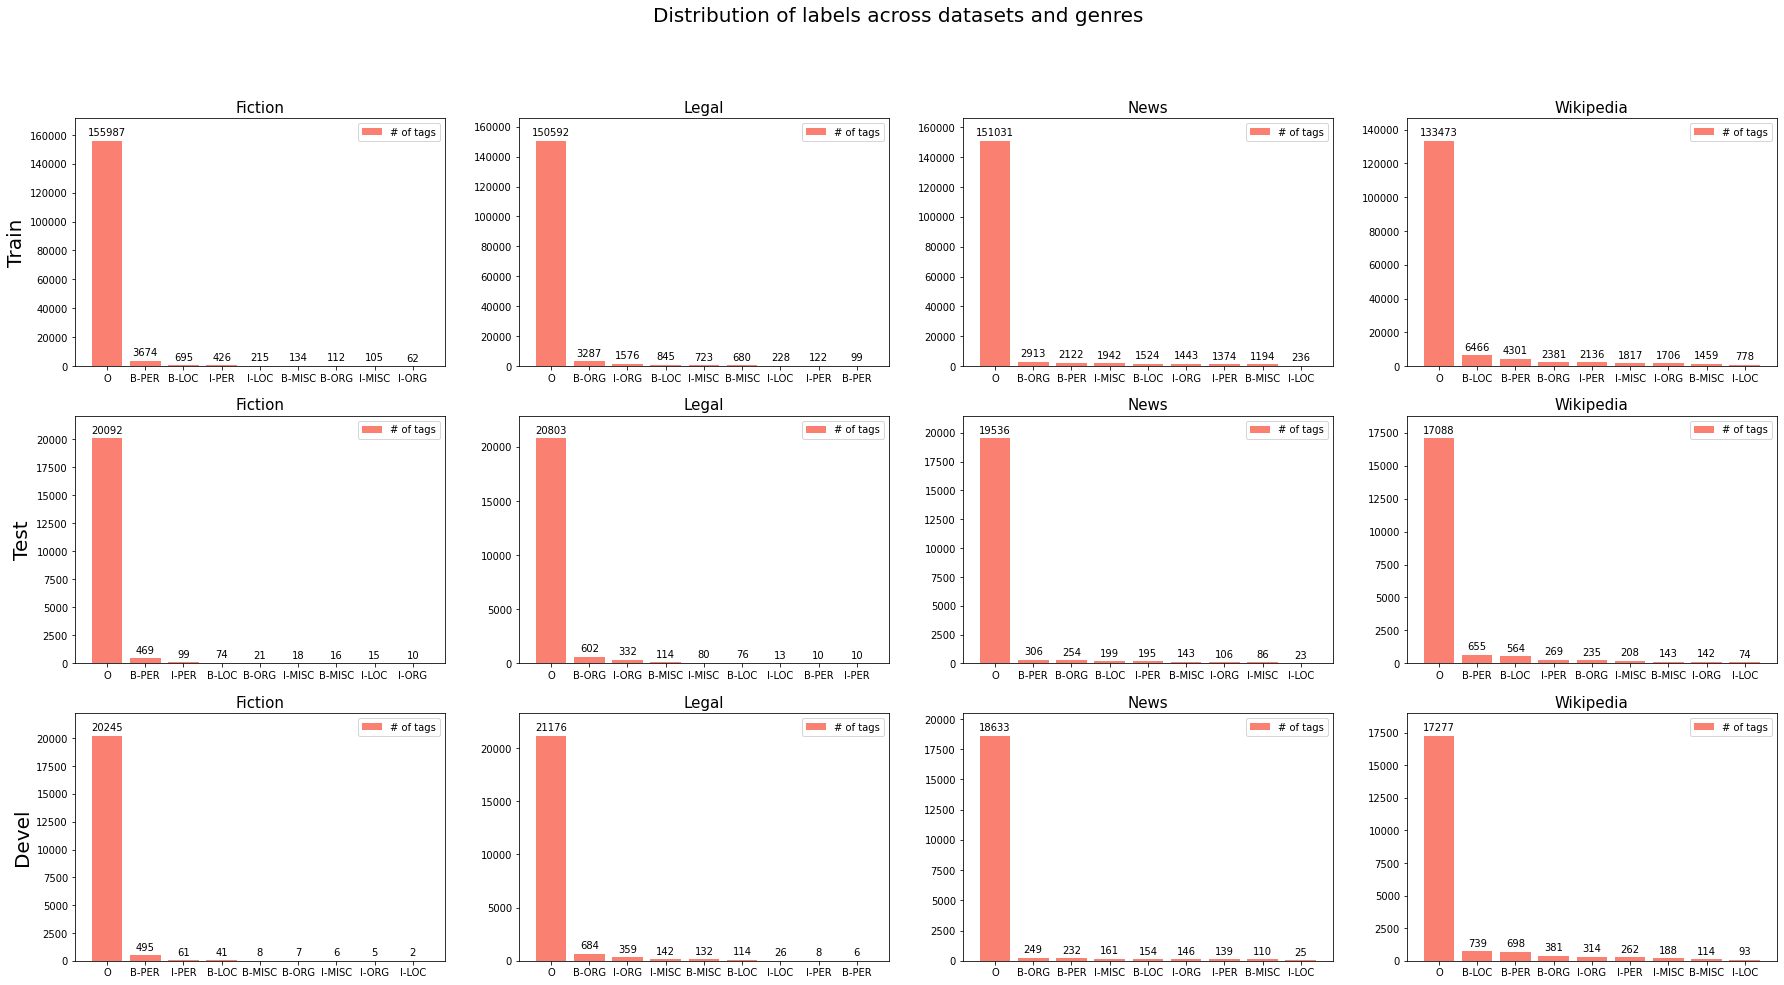

In [262]:
def plot_tag_distribution():
    data_dirs = get_train_devel_test_conllup_file_dirs()
    genres = [data_dirs[genre_dir] for genre_dir in data_dirs]
    fig, ax = plt.subplots(len(data_dirs),len(genres[0]))
    fig.suptitle("Distribution of labels across datasets and genres",  fontsize=20)
    fig.set_size_inches(30.5, 15.5)
    for i, dataset in enumerate(reversed(data_dirs)):
        for j, genre_dir_path in enumerate(data_dirs[dataset]):
            genre = genre_dir_path.split(os.sep)[-2]
            df = load_csv_files_from_dir(genre_dir_path)
            value_counts = df["CONLL:NER"].value_counts()
            rects = ax[i][j].bar(value_counts.keys(), value_counts.values, color="salmon", label="# of tags")
            ax[i][j].bar_label(rects, padding=3)
            ax[i][j].legend()
            if j == 0:
                ax[i][j].set_ylabel(f"{dataset[0].upper()}{dataset[1:]}").set_fontsize(20)
            ax[i][j].set_title(f"{genre[0].upper()}{genre[1:]}").set_fontsize(15)
            ax[i][j].set_ylim(0, max(value_counts.values) * 1.1)
        
plot_tag_distribution()
